## Tutorial : Running minimal inference examples with diffuser.

For this tutorial, we will use my pre-trained lora embedding that is pretrained on pop-arts, illustrations and pixar footages.

To get started install this package with:

```bash
pip install git+https://github.com/cloneofsimo/lora.git
```


In [ ]:
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    "cuda:6"
)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

prompt = "style of <s1><s2>, baby lion"
torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]

image  # nice. diffusers are cool.


Now there is two way to LORA this model. You can 1. monkey-patch it, or 2. update the weight inplaced.

Monkey-patching is essentially replacing the linear layer with a lora-linear layer, which is the following

$$
x_2 = Wx_1 + A B^T x_1
$$

On the other hand, weight updating is literally replacing the original weight with the LORA weight. This is the following

$$
W' = W + A B^T
$$

You might find this weird. Just having the weight updated is the logical option. Why even monkey-patch when you can add the weights? Well, by keeping the LORA weights we can perform _weight mixing_ dynamically. We can't do this if we just update the weight, because the weight is fixed. This is the reason why we have two options. You can adjust the weight with `tune_lora_scale` function.


In [ ]:
from lora_diffusion import tune_lora_scale, patch_pipe
import matplotlib.pyplot as plt
prompt = 'a <s1><s2> at a beach with a view of the seashore'

# concatenate 3 images and display them use plt
tune_lora_scale(pipe.text_encoder,1)
tune_lora_scale(pipe.unet, 0)
torch.manual_seed(231)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
plt.imshow(image)
plt.show()
for i in ['_1','_0.1','_0.01','_0.001']:
    patch_pipe(
        pipe,
        f"../exps/output_dog{i}/step_900.safetensors",
        patch_text=True,
        patch_ti=True,
        patch_unet=True,
    )

    tune_lora_scale(pipe.unet, 1)
    tune_lora_scale(pipe.text_encoder, 1)

    image = pipe(prompt, num_inference_steps=50, guidance_scale=6).images[0]
    plt.imshow(image)
    plt.show()

In [94]:
from lora_diffusion.lora import _find_modules,DEFAULT_TARGET_REPLACE,LoraInjectedLinear
from torchvision.utils import make_grid
images = []
patch_pipe(
    pipe,
    f"../exps/output_dog_0.001/step_900.safetensors",
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
)
prompt = 'a dog in grand canyon'
tune_lora_scale(pipe.unet, 1)
tune_lora_scale(pipe.text_encoder, 1)
torch.manual_seed(231)
image = pipe(prompt, num_inference_steps=50, guidance_scale=6).images[0]
images.append(image)

for scale in [0.5,0.1,0]:
    cnt = 0
    for target, name, module in _find_modules(pipe.unet, DEFAULT_TARGET_REPLACE,search_class=[LoraInjectedLinear]):
        # print(name)
        if module.linear.in_features == 768 and (name == 'to_k' or name == 'to_v'):
            # print(cnt, name)
            module.scale = scale
        cnt += 1 
        
    image = pipe(prompt, num_inference_steps=50, guidance_scale=6).images[0]
    images.append(image)


<s1>
The tokenizer already contains the token <s1>.
Replacing <s1> embedding.
<s2>
The tokenizer already contains the token <s2>.
Replacing <s2> embedding.


100%|██████████| 50/50 [00:03<00:00, 13.07it/s]


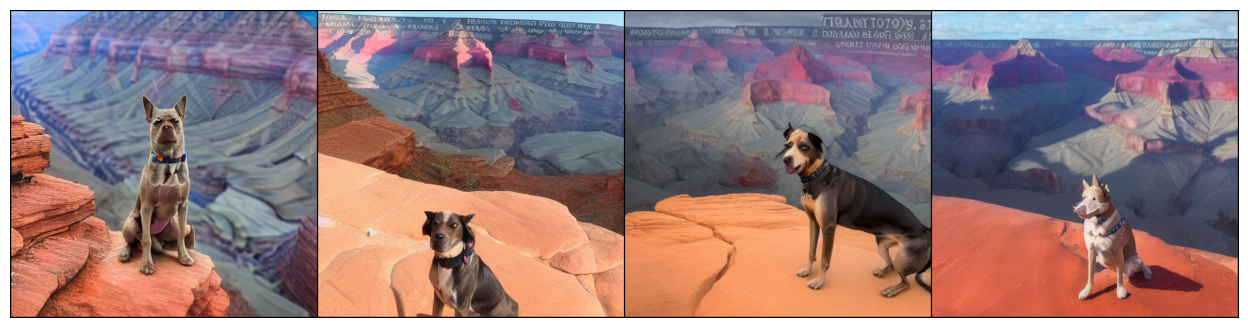

In [95]:
# change a PIL.Image to  tensor
import torchvision.transforms as transforms 
# import rearrange
from PIL import Image
import numpy as np
from einops import rearrange

transform = transforms.ToTensor()
images_ts = torch.stack([transform(image) for image in images])
# save images to a grid
grid = make_grid(images_ts, nrow=4, normalize=True, scale_each=True)
# set plt figure size to (4,16)
plt.figure(figsize=(16,4))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()
# remove the axis
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
img = Image.fromarray(grid.astype(np.uint8))
img.save(f'{prompt}_768.jpg')

In [ ]:
tune_lora_scale(pipe.unet, 0.3) tune_lora_scale(pipe.text_encoder, 0.3)
torch.manual_seed(0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]
image


Nice. Let's try another example:


In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    "cuda"
)

prompt = "superman, style of <s1><s2>"
torch.manual_seed(1)
image = pipe(prompt, num_inference_steps=50, guidance_scale=4).images[0]

image


In [ ]:
patch_pipe(
    pipe,
    "../example_loras/lora_popart.safetensors",
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
)
torch.manual_seed(1)
tune_lora_scale(pipe.unet, 1.0)
tune_lora_scale(pipe.text_encoder, 1.0)
image = pipe(prompt, num_inference_steps=50, guidance_scale=4).images[0]
image


That is good pop-art style, but we might get a better result with lower $\alpha$ for both text encoder and unet.


In [ ]:
torch.manual_seed(1)
tune_lora_scale(pipe.unet, 0.5)
tune_lora_scale(pipe.text_encoder, 0.5)

image = pipe(prompt, num_inference_steps=50, guidance_scale=4.0).images[0]
image.save("../contents/pop_art.jpg")
image


# Appendix : To make stuff on the readme


In [ ]:
prompt = "baby lion in style of <s1><s2>"

patch_pipe(
    pipe,
    "../example_loras/lora_disney.safetensors",
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
)
torch.manual_seed(6)
tune_lora_scale(pipe.unet, 0.5)
tune_lora_scale(pipe.text_encoder, 0.5)
image = pipe(prompt, num_inference_steps=50, guidance_scale=5).images[0]
image.save("../contents/disney_lora.jpg")
image


#


In [ ]:

patch_pipe(
    pipe,
    "../example_loras/lora_krk.safetensors",
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
)

example_prompts = [
    "painting of <TOK>, a starry night, style of vincent van gogh",
    "portrait of <TOK> by mario testino 1950, 1950s style, hair tied in a bun, taken in 1950, detailed face of <TOK>, sony a7r",
    "photof of <TOK>, 50mm, sharp, muscular, detailed realistic face, hyper realistic, perfect face, intricate, natural light, <TOK> underwater photoshoot,collarbones, skin indentation, Alphonse Mucha, Greg Rutkowski",
    "a photo of <TOK> in advanced organic armor, biological filigree, detailed symmetric face, flowing hair, neon details, intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, octane, art by Krenz Cushart , Artem Demura, Alphonse Mucha, digital cgi art 8K HDR by Yuanyuan Wang photorealistic",
    "a photo of <TOK> on the beach, small waves, detailed symmetric face, beautiful composition",
    "a photo of <TOK> rainbow background, wlop, dan mumford, artgerm, liam brazier, peter mohrbacher, jia zhangke, 8 k, raw, featured in artstation, octane render, cinematic, elegant, intricate, 8 k",
    "photo of Summoner <TOK> with a cute water elemental, fantasy illustration, detailed face, intricate, elegant, highly detailed, digital painting, artstation, concept art, wallpaper, smooth, sharp focus, illustration, art by artgerm and greg rutkowski",
    "<TOK>, cyberpunk 2077, 4K, 3d render in unreal engine",
    "a pencil sketch of <TOK>",
    "a minecraft render of <TOK>",
    "young woman <TOK>, eden, intense eyes, tears running down, crying, vaporwave aesthetic, synthwave, colorful, psychedelic, crown, long gown, flowers, bees, butterflies, ribbons, ornate, intricate, digital painting, artstation, concept art, smooth, sharp focus, illustration of <wday>, art by artgerm and greg rutkowski and alphonse mucha",
    "<TOK> in a construction outfit",
]

outs = []
tune_lora_scale(pipe.unet, 0.5)
tune_lora_scale(pipe.text_encoder, 0.5)
for idx, prompt in enumerate(example_prompts):
    prompt = prompt.replace("<TOK>", "<s1><s2>")
    torch.manual_seed(idx)
    image = pipe(prompt, num_inference_steps=50, guidance_scale=6).images[0]
    outs.append(image)


In [ ]:
from lora_diffusion import image_grid

imgs = image_grid(outs, 3, 4)
imgs.save("../contents/lora_pti_example.jpg")
imgs

## Using extended LoRA


In [ ]:

from lora_diffusion import UNET_EXTENDED_TARGET_REPLACE

patch_pipe(
    pipe,
    "../example_loras/modern_disney_svd.safetensors",
    patch_text=True,
    patch_ti=True,
    patch_unet=True,
    unet_target_replace_module=UNET_EXTENDED_TARGET_REPLACE
)

In [ ]:
prompt = "modern disney style, cute baby lion"

SC = 2.5

torch.manual_seed(0)
tune_lora_scale(pipe.unet, SC)
tune_lora_scale(pipe.text_encoder, SC)

img_ori = pipe(
    prompt,
    num_inference_steps=50,
    guidance_scale=7.5,
    height=640,
    width=512,
).images[0]

In [ ]:
img_ori